### Movie genres analysis

Dataset downloaded from: https://www.kaggle.com/jrobischon/wikipedia-movie-plots

In [1]:
import warnings
warnings.filterwarnings("ignore")

# nltk
from nltk.stem import LancasterStemmer
from nltk.corpus import wordnet
import nltk

# data visualisation
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import pylab as pl
import math
import numpy as np
%matplotlib inline

# data wrangling
import re

In [2]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')

In [3]:
df.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
Release Year        34886 non-null int64
Title               34886 non-null object
Origin/Ethnicity    34886 non-null object
Director            34886 non-null object
Cast                33464 non-null object
Genre               34886 non-null object
Wiki Page           34886 non-null object
Plot                34886 non-null object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


# Cleaning "Genre" column

In [5]:
sum(df['Genre'] == 'unknown')

6083

In [6]:
# first remove missing values
df = df[(df['Genre'] != 'unknown') & (df['Genre'] != '')]

In [7]:
# How many unique genre values there are in the dataset?
df['Genre'].nunique()

2264

In [8]:
df['Genre'].value_counts()

drama                                                       5964
comedy                                                      4379
horror                                                      1167
action                                                      1098
thriller                                                     966
romance                                                      923
western                                                      865
crime                                                        568
adventure                                                    526
musical                                                      467
crime drama                                                  464
romantic comedy                                              461
science fiction                                              418
film noir                                                    345
mystery                                                      310
war                      

In [9]:
df['Genre'].unique()[1800:2000]

array(['black comedy/thriller', 'action - comedy', 'drama/social',
       'social/action', 'fantasy/children', 'mystery/thriller/drama',
       'comedy/drama/romance', 'social satire', 'political satire',
       'found footage / horror', 'erotica/thriller',
       'silent hills studio', 'yash raj films',
       'political crime thriller', 'panorama studios', 'sex/drama',
       'bbc films', 'movies by the mob & knkspl', 'action/crime ttriller',
       'colour yellow productions & eros international',
       'viacom 18 motion pictures',
       'bholenath movies & cinekorn entertainment', 'biographic',
       'dharma productions, red chillies entertainment & b.r films',
       'social/comedy', 'drama/disaster', 'k9 films',
       'horror / thriller / drama', 'drama / documentary',
       'fantasy / horror', 'satirical comedy', 'romance / thriller',
       'romantic action', 'love, drama', 'romance-action',
       'romance/ drama', 'period romance', 'horror / found footage',
       'actio

In [10]:
# How many genre values have less than 10 occurencies?
sum(df['Genre'].value_counts() == 1)

1550

We have 1555 genres, that appear just one time in the dataframe. Based on results of `value_counts()` function, most of them could be grouped together, but because the values are free text, they are very incoherent. We need to apply some data cleaning.

### NLTK approach

My first thought was to implement some more automatic approach using nltk library. 

Steps: 
* First I extract the group, where more than one word describes genre and keep only nouns. My assumption is that for e.g. `short action` or `historical romance` the adjective only adds the context, while the noun is the major genre for the movie. I remove `short` and `historical` from the description.
* Next, if there are more nouns in genre description left, e.g. `comedy drama` I take only the first one. This is a simplification I'm choosing to make, with the assumption that first genre is most fitted.
* Lastly, having a single word in each genre row, I group them by their stemming. E.g. I will be able to match `animated` and `animation` or `romance` and `romantic`.



In [11]:
lancaster = LancasterStemmer()

In [12]:
print(lancaster.stem("romantic"))

rom


In [13]:
print(lancaster.stem("romance"))

rom


In [14]:
# split genre description containing more than 1 word into a list
df['nltk_cleaned'] =  df['Genre'].apply(lambda x: re.split(' |,|-|/', x))

In [15]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,nltk_cleaned
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,[western]
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,[comedy]
10,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,NaN,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...,[short]
11,1906,From Leadville to Aspen: A Hold-Up in the Rockies,American,Francis J. Marion and Wallace McCutcheon,NaN,short action/crime western,https://en.wikipedia.org/wiki/From_Leadville_t...,The film features a train traveling through th...,"[short, action, crime, western]"
12,1906,Kathleen Mavourneen,American,Edwin S. Porter,NaN,short film,https://en.wikipedia.org/wiki/Kathleen_Mavourn...,Irish villager Kathleen is a tenant of Captain...,"[short, film]"


In [16]:
# change to array to speed up the transformations
array = np.array(df[['Release Year', 'nltk_cleaned']])

In [17]:
array.shape

(28803, 2)

In [18]:
array[0]

array([1903, list(['western'])], dtype=object)

In [19]:
# first step, make sure genre is only one noun
for i in range(len(array)):
    if len(array[i][1]) > 1:
        for element in array[i][1]:
            try:
                if nltk.pos_tag([element])[0][1] != 'NN':
                    array[i][1].remove(element)
            except IndexError:
                continue
    array[i][1] = array[i][1][0]

In [20]:
array[:20]

array([[1903, 'western'],
       [1904, 'comedy'],
       [1906, 'short'],
       [1906, 'action'],
       [1906, 'film'],
       [1907, 'biographical'],
       [1907, 'comedy'],
       [1907, 'comedy'],
       [1908, 'drama'],
       [1908, 'drama'],
       [1908, 'comedy'],
       [1908, 'adventure'],
       [1908, 'drama'],
       [1908, 'western'],
       [1909, 'drama'],
       [1909, 'drama'],
       [1909, 'drama'],
       [1910, 'drama'],
       [1910, 'comedy'],
       [1910, 'drama']], dtype=object)

In [21]:
df2 = pd.DataFrame(array)

In [22]:
df2['stem'] = df2[1].apply(lambda x: lancaster.stem(x))

In [23]:
df2.head(10)

,0,1,stem
0,1903,western,western
1,1904,comedy,comedy
2,1906,short,short
3,1906,action,act
4,1906,film,film
5,1907,biographical,biograph
6,1907,comedy,comedy
7,1907,comedy,comedy
8,1908,drama,dram
9,1908,drama,dram


In [24]:
df2['stem'].nunique()

299

In [25]:
df2['stem'].value_counts()

dram            7211
comedy          6400
act             2088
hor             1407
rom             1342
crim            1287
thriller        1143
western          868
sci              787
anim             651
adv              623
mus              480
famy             423
war              410
film             396
mystery          356
fantasy          337
biograph         239
                 222
suspens          128
short            124
world             98
spy               98
hist              90
soc               84
docu              81
biop              76
ser               73
mart              73
superhero         62
                ... 
docufict           1
romance;           1
action;            1
rajendr            1
arjun              1
wartim             1
tim                1
inuit              1
comedy[not         1
from               1
sou                1
raghav             1
legend             1
yogesh             1
bbc                1
mahesh             1
tapa         

In [26]:
df2 = df2[df2['stem'] != '']

In [27]:
sum(df2['stem'].value_counts() == 1)

149

In [28]:
df2.reset_index(inplace=True)

In [29]:
popular_nltk_genres = df2['stem'].value_counts()[:20].index
df2 = df2[df2['stem'].isin(popular_nltk_genres)]

In [30]:
stem_dict = {}
for i in range(len(df2.index)):
    if df2.iloc[i]['stem'] not in stem_dict.keys():
        stem_dict[df2.iloc[i]['stem']] = [df2.iloc[i][1]]
    else:
        stem_dict[df2.iloc[i]['stem']].append(df2.iloc[i][1])
    

In [31]:
stem_dict.keys()

dict_keys(['western', 'comedy', 'short', 'act', 'film', 'biograph', 'dram', 'adv', 'fantasy', 'hor', 'crim', 'mystery', 'rom', 'war', 'thriller', 'mus', 'anim', 'sci', 'suspens', 'famy'])

In [32]:
for key in stem_dict.keys():
    if len(stem_dict[key]) > 1:
        stem_dict[key] = stem_dict[key][0]

In [33]:
df2['stem_genre'] = df2['stem'].apply(lambda x: stem_dict[x])

In [34]:
df2 = df2.groupby([0, 'stem_genre'], as_index=False).count()

In [35]:
df2.drop(['index', 'stem'], inplace=True, axis=1)
df2.columns = ['Release year', 'stem_genre', 'stem_count']

In [36]:
df2.head()

,Release year,stem_genre,stem_count
0,1903,western,1
1,1904,comedy,1
2,1906,action,1
3,1906,film,1
4,1906,short,1


### Manual approach

The nltk approach was a bit complicated, it required moving the operations to numpy arrays, as computations on pandas DataFrame were too heavy. Was it necessary? Actually scanning throught the values that appear in the genre column made me think that a simple lambda function would suffice to extract most popular genres. It seemed simple enough as I know the scope of possible movie genres fairly well. Let's see and compare it against nltk approach. I will use the measure of the number of values that appear only once after cleaning. For nltk it was down from 1550 to 149.

Things I noticed that could provide a simple fix for most popular columns:
* group all anime in one category (e.g. change `anime fantasy` to simple `anime`)
* group all kinds of sci-fi spellings into one
* group animated movies (`animated` to `animation`)
* group romance movies (`romantic` to `romace`)
* split columns like `comedy-drama` or `horror/action` and extracting only the first genre mentioned. My assumption is that the first is the most descriptive in general. I need high level genres and I decided this is the way to go.


In [37]:
re.split('-|/|,', 'comedy/drama')[0]

'comedy'

In [38]:
df['manually_cleaned'] = df['Genre'].apply(lambda x: 'anime' if 'anime' in x.lower() else
                                         ('sci-fi' if 'science-fiction' in x.lower() else
                                         ('sci-fi' if 'science fiction' in x.lower() else 
                                         ('animation' if 'animated' in x.lower() else 
                                         ('romance' if 'romantic' in x.lower() else 
                                          (re.split(' |-|/|,', x)[0] if len(re.split(' |-|/|,', x)) > 1
                                          and re.split(' |-|/|,', x)[0] != 'sci' else x))))))

In [39]:
df['manually_cleaned'].nunique()

365

In [40]:
df['manually_cleaned'].value_counts()

drama             6873
comedy            5623
action            2045
romance           1974
horror            1384
crime             1278
thriller          1061
western            923
sci-fi             770
animation          744
musical            707
adventure          603
war                407
family             394
mystery            354
film               345
fantasy            314
biography          214
historical         204
social             169
anime              143
suspense           127
world               98
spy                 97
documentary         80
martial             72
serial              71
short               71
biopic              71
sports              63
                  ... 
inuit                1
raja                 1
united               1
sci-fi/fantasy       1
psy                  1
urban                1
legend               1
double               1
yogesh               1
bbc                  1
biogtaphy            1
mahesh               1
superheroes

In [41]:
sum(df['manually_cleaned'].value_counts() == 1)

188

### Compare top genres with movie count from 2 ways of data cleaning

In [42]:
# from manual cleaning
popular_genres = df['manually_cleaned'].value_counts()[:20].index
popular_genres

Index(['drama', 'comedy', 'action', 'romance', 'horror', 'crime', 'thriller',
       'western', 'sci-fi', 'animation', 'musical', 'adventure', 'war',
       'family', 'mystery', 'film', 'fantasy', 'biography', 'historical',
       'social'],
      dtype='object')

In [43]:
df3 = df[df['manually_cleaned'].isin(popular_genres)]

In [44]:
df3 = df3.groupby(['Release Year', 'manually_cleaned'])[['Title']].count()

In [45]:
df3.reset_index(inplace=True)

In [46]:
df3 = df3.pivot_table(index='Release Year', columns='manually_cleaned', values='Title')

In [47]:
df3.fillna(0, inplace=True)

In [48]:
df3.head()

manually_cleaned,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,film,historical,horror,musical,mystery,romance,sci-fi,social,thriller,war,western
Release Year,,,,,,,,,,,,,,,,,,,,
1903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1904,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1907,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1909,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


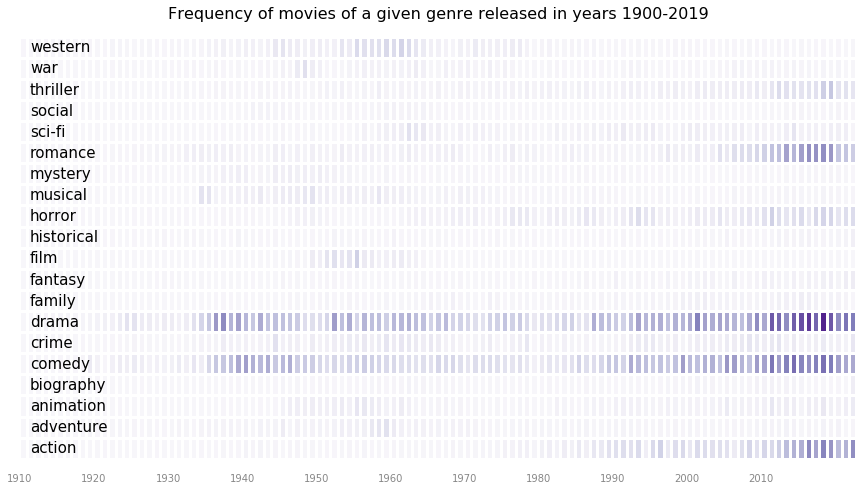

In [49]:
genre, decade = np.mgrid[:df3.shape[0]+1, :df3.shape[1]+1]
fig, ax = pl.subplots(figsize=(15, 8))
# ax.set_aspect("equal")
pl.pcolormesh(genre ,decade , df3.values, cmap='Purples', edgecolor='w', linewidth=2, vmin=-10, vmax=200)
pl.xlim(0, df3.shape[0])

# y axis
ax.yaxis.set_major_locator(MaxNLocator(20))
ax.set_yticklabels(df3.columns, fontsize=15, fontdict={'horizontalalignment':'left'})
y_loc = ax.get_yticks()
ax.set_yticks(y_loc + 0.6)
ax.tick_params(axis='y', direction='in', pad=-10, colors='black', width=20)

# x axis
ax.xaxis.set_major_locator(MaxNLocator(12))
ax.set_xticklabels([x for x in df3.index if x % 10 == 0])
ax.tick_params(axis='x', pad=10, labelcolor='#878787')


# remove frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')

ax.set_title('Frequency of movies of a given genre released in years 1900-2019', fontsize=16);

In [50]:
# from nlth approach
df2 = df2.pivot_table(index='Release year', columns='stem_genre', values='stem_count')
df2.fillna(0, inplace=True)
df2.head()

stem_genre,action,adventure,animation,biographical,comedy,crime,drama,family,fantasy,film,horror,musical,mystery,romance,science,short,suspense,thriller,war,western
Release year,,,,,,,,,,,,,,,,,,,,
1903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1904,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1906,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1907,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


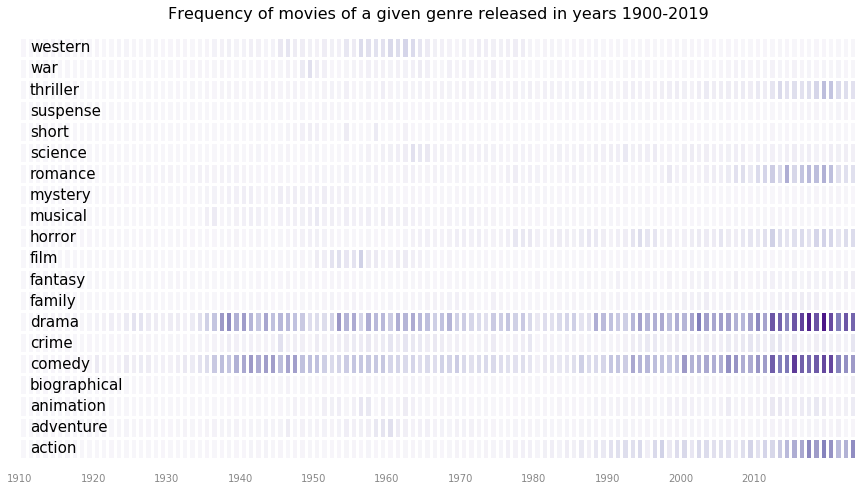

In [51]:
genre, decade = np.mgrid[:df2.shape[0]+1, :df2.shape[1]+1]
fig, ax = pl.subplots(figsize=(15, 8))
# ax.set_aspect("equal")
pl.pcolormesh(genre ,decade , df2.values, cmap='Purples', edgecolor='w', linewidth=2, vmin=-10, vmax=200)
pl.xlim(0, df2.shape[0])

# y axis
ax.yaxis.set_major_locator(MaxNLocator(20))
ax.set_yticklabels(df2.columns, fontsize=15, fontdict={'horizontalalignment':'left'})
y_loc = ax.get_yticks()
ax.set_yticks(y_loc + 0.6)
ax.tick_params(axis='y', direction='in', pad=-10, colors='black', width=20)

# x axis
ax.xaxis.set_major_locator(MaxNLocator(12))
ax.set_xticklabels([x for x in df2.index if x % 10 == 0])
ax.tick_params(axis='x', pad=10, labelcolor='#878787')


# remove frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')

ax.set_title('Frequency of movies of a given genre released in years 1900-2019', fontsize=16);